## REINFORCE: REINFORCE algorithm

target funct:
$$
J(θ) = \mathbb{E}_{S_0}[V^{π_θ}(S_0)]
$$

derivative of the above:
$$
\begin{aligned}
∇_θJ(θ) &∝ \sum_{s \in S} v^{π_θ}(s) \sum_{a \in A} Q^{π_θ}(s, a)∇_θπ_θ(a | s) \\ 
  &= \sum_{s \in S} v^{π_θ}(s) \sum_{a \in A}π_θ(a | s) Q^{π_θ}(s, a)\frac{∇_θπ_θ(a | s)}{π_θ(a | s)} \\ 
  &= \mathbb{E}_{π_θ}[ Q^{π_θ}(s, a)∇_θ \logπ_θ(a | s)]
\end{aligned}
$$

MC sampling:
$$
J(θ) = \mathbb{E}_{π_0}[\sum_{t=0}^T(\sum_{t'=t}^Tγ^{t'-t}r_{t'})∇_θ \logπ_θ(a_t | s_t)]
$$

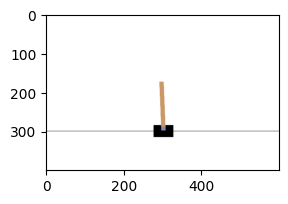

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    over = terminated or truncated

    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
        over = True
    
    #没坚持到最后,扣分
    if over and self.step_n < 200:
        reward = -1000

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch
	
#定义模型,评估状态下每个动作的价值
model = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
	torch.nn.Softmax(dim=1),
)

model

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Softmax(dim=1)
)

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
	state = []
	action = []
	reward = []

	s = env.reset()
	o = False
	while not o:
		# 根据环境采样
		prob = model(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
		a = random.choices(range(2), weights=prob, k=1)[0]
		
		ns, r, o = env.step(a)

		state.append(s)
		action.append(a)
		reward.append(r)
  
		s = ns

		if show:
			display.clear_output(wait=True)
			env.show()
  
	state = torch.FloatTensor(state).reshape(-1, 4)
	action = torch.LongTensor(action).reshape(-1, 1)
	reward = torch.FloatTensor(reward).reshape(-1, 1)

	return state, action, reward, reward.sum().item()

state, action, reward, reward_sum = play()

reward_sum

C:\Users\fanyu\AppData\Local\Temp\ipykernel_39492\2909018427.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor(state).reshape(-1, 4)


-976.0

In [4]:
#训练
def train():
	model.train()
	# model_delay.eval()  # code changed here
	optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
	# loss_fn = torch.nn.MSELoss()

	#共更新N轮数据
	for epoch in range(1000):
		# y一个epoch玩N步
		steps = 0
		while steps < 200:
			# 玩一局，得到数据
			state, action, reward, _ = play()
			steps += len(state)

			#计算当前state的价值，即Q(state, action), 用MC估计
			value = []
			for i in range(len(reward)):
				s = 0
				for j in range(i, len(reward)):
					s += reward[j] * 0.99**(j - i)
				value.append(s)
			value = torch.FloatTensor(value).reshape(-1, 1)

			# 重新计算动作的概率
			prob = model(state).gather(dim=1, index=action)
  
			# 求Q最大的导函数 -> partial value / partial action
			prob = (prob + 1e-8).log() * value
			for i in range(len(prob)):
				prob[i] = prob[i] * 0.99 ** i
			loss = -prob.mean()

			loss.backward()
			optimizer.step()
			optimizer.zero_grad()


		if epoch % 100 == 0:
			test_result = sum([play()[-1] for _ in range(20)]) / 20
			print(epoch, loss.item(), test_result)

train()

0 -627.2378540039062 -983.25
100 11.657674789428711 -333.7
200 12.974897384643555 92.4
300 13.778868675231934 200.0
400 12.777483940124512 200.0
500 13.124218940734863 200.0
600 12.778105735778809 200.0
700 11.676695823669434 200.0
800 14.949150085449219 200.0
900 12.241456031799316 200.0


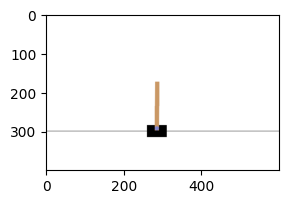

200.0

In [5]:
play(True)[-1]